
# Satellite Geometry — YAML-Driven Generator + 3D Visualizer

This notebook replaces the Java text inputs with a **YAML** description and reproduces the geometry table:
`AZIMUTH,ELEVATION,EXPOSED,FRONTAL,DRAG_MUL,SRP_X_MUL,SRP_Y_MUL,SRP_Z_MUL,POW_MUL,ABS_MUL,EMI_MUL`

It also includes a **3D renderer** (matplotlib) to visualize the body and deployed panels.


## YAML schema (commented)

In [1]:

# YAML schema with hinge logic (PERP / PETAL), quadrant, multiplicity and optional overrides.
schema_yaml = """
meta:
  name: "EXAMPLE_GEOMETRY"
  version: 2
grid:
  az_step_deg: 5
  el_step_deg: 5
  az_start_deg: -180
  az_stop_deg: 180
  el_start_deg: -90
  el_stop_deg: 90
spacecraft:
  body:
    dimensions_m: [0.2, 0.4, 0.2]
    facet_solar_area_m2: [0.0, 0.04, 0.0, 0.0, 0.0, 0.0]
    alpha_abs: 0.6
    epsilon_emi: 0.8
  deployables:
    - name: "panel_1"
      type: PERP
      attach_face: "+X"
      quadrant: PLUS
      angle_deg: 90
      area_inside_m2: 0.0
      area_outside_m2: 0.04
      multiplicity: SINGLE
    - name: "panel_2"
      type: PERP
      attach_face: "-X"
      quadrant: PLUS
      angle_deg: 90
      area_inside_m2: 0.0
      area_outside_m2: 0.04
      multiplicity: SINGLE
    - name: "panel_3"
      type: PETAL
      attach_face: "+Y"
      quadrant: PLUS
      angle_deg: 180
      area_inside_m2: 0.04
      area_outside_m2: 0.0
      multiplicity: SINGLE
    - name: "panel_4"
      type: PETAL
      attach_face: "+Y"
      quadrant: MINUS
      angle_deg: 180
      area_inside_m2: 0.04
      area_outside_m2: 0.0
      multiplicity: SINGLE
coefficients:
  drag_coeff: 2.2
  srp_reflectivity: 0.3
outputs:
  file: "geometry_output.csv"
"""
from pathlib import Path
Path("/mnt/data/sat_geometry_schema_v2.yaml").write_text(schema_yaml, encoding="utf-8")
print("Saved schema to /mnt/data/sat_geometry_schema_v2.yaml")


Saved schema to /mnt/data/sat_geometry_schema_v2.yaml


In [2]:

import math, yaml, csv
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def unit(v):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    return v / n if n else v

def rodrigues_rotate(vec, axis, angle_rad):
    v = np.asarray(vec, float)
    k = unit(axis)
    c = math.cos(angle_rad)
    s = math.sin(angle_rad)
    return v*c + np.cross(k, v)*s + k*(np.dot(k, v))*(1-c)

FACE_BASIS = {
    "+X": {"n": np.array([1,0,0],float),  "u": np.array([0,1,0],float), "v": np.array([0,0,1],float)},
    "-X": {"n": np.array([-1,0,0],float), "u": np.array([0,1,0],float), "v": np.array([0,0,1],float)},
    "+Y": {"n": np.array([0,1,0],float),  "u": np.array([1,0,0],float), "v": np.array([0,0,1],float)},
    "-Y": {"n": np.array([0,-1,0],float), "u": np.array([1,0,0],float), "v": np.array([0,0,1],float)},
    "+Z": {"n": np.array([0,0,1],float),  "u": np.array([1,0,0],float), "v": np.array([0,1,0],float)},
    "-Z": {"n": np.array([0,0,-1],float), "u": np.array([1,0,0],float), "v": np.array([0,1,0],float)},
}

@dataclass
class Facet:
    name: str
    normal: np.ndarray
    area: float
    has_solar: bool
    alpha_abs: float
    epsilon_emi: float

def load_yaml(path: str) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def body_facets(body_cfg) -> List[Facet]:
    x,y,z = body_cfg["dimensions_m"]
    areas = [y*z, y*z, x*z, x*z, x*y, x*y]
    solar = body_cfg.get("facet_solar_area_m2", [0,0,0,0,0,0])
    alpha = float(body_cfg.get("alpha_abs", 0.6))
    eps   = float(body_cfg.get("epsilon_emi", 0.8))

    facets = []
    for idx, key in enumerate(["+X","-X","+Y","-Y","+Z","-Z"]):
        facets.append(Facet(
            name=f"body_{key}", normal=FACE_BASIS[key]["n"],
            area=float(areas[idx]), has_solar=bool(solar[idx] > 0),
            alpha_abs=alpha, epsilon_emi=eps
        ))
    return facets

def panel_facets(pan_cfgs: List[Dict]) -> List[Facet]:
    facets = []
    for p in pan_cfgs:
        attach = p["attach_face"]
        basis = FACE_BASIS[attach]
        n_face, u, v = basis["n"], basis["u"], basis["v"]
        if p["type"].upper() == "PERP":
            hinge_axis = u if p.get("hinge_axis_hint","U") == "U" else v
        else:
            hinge_axis = v if p.get("hinge_axis_hint","V") == "V" else u
        angle = math.radians(float(p["angle_deg"]))
        if p["quadrant"].upper() == "MINUS":
            angle = -angle
        n_panel = rodrigues_rotate(n_face, hinge_axis, angle)
        has_solar = (float(p.get("area_inside_m2",0)) + float(p.get("area_outside_m2",0))) > 0
        area = float(p.get("width_m",0)) * float(p.get("height_m",0))
        if area <= 0:
            area = max(float(p.get("area_inside_m2",0)), float(p.get("area_outside_m2",0)))
            if area <= 0:
                area = 0.03
        alpha = float(p.get("alpha_abs", 0.9))
        eps   = float(p.get("epsilon_emi", 0.85))
        count = {"SINGLE":1, "DOUBLE":2, "TRIPLE":3}.get(p.get("multiplicity","SINGLE").upper(),1)
        for i in range(count):
            facets.append(Facet(
                name=f'{p.get("name","panel")}_{i+1}',
                normal=unit(n_panel),
                area=area,
                has_solar=has_solar,
                alpha_abs=alpha,
                epsilon_emi=eps,
            ))
    return facets

def sph_to_cart(az_deg, el_deg):
    az = math.radians(az_deg); el = math.radians(el_deg)
    cosel = math.cos(el)
    return np.array([cosel*math.cos(az), cosel*math.sin(az), math.sin(el)], float)

def make_lut(cfg: Dict) -> pd.DataFrame:
    grid = cfg["grid"]
    sp = cfg["spacecraft"]
    coeff = cfg.get("coefficients", {})
    drag_coeff = float(coeff.get("drag_coeff", 2.2))
    srp_refl   = float(coeff.get("srp_reflectivity", 0.3))
    facets = body_facets(sp["body"]) + panel_facets(sp.get("deployables", []))
    A_ref = sum(f.area for f in facets) / 6.0 if facets else 1.0
    rows = []
    for az in np.arange(grid["az_start_deg"], grid["az_stop_deg"]+1e-9, grid["az_step_deg"]):
        for el in np.arange(grid["el_start_deg"], grid["el_stop_deg"]+1e-9, grid["el_step_deg"]):
            u = sph_to_cart(az, el)
            exposed = frontal = pow_mul = abs_mul = 0.0
            emi_mul = sum(f.epsilon_emi * f.area for f in facets)
            srp_vec = np.zeros(3)
            for f in facets:
                ndotu = float(np.dot(f.normal, u))
                if ndotu > 0:
                    exposed += f.area
                    frontal += f.area * ndotu
                    if f.has_solar: pow_mul += f.area * ndotu
                    abs_mul += f.alpha_abs * f.area * ndotu
                    srp_vec += f.area * ndotu * f.normal
            srp_vec *= srp_refl
            drag_mul = drag_coeff * frontal / max(A_ref, 1e-6)
            rows.append([
                math.radians(az), math.radians(el), exposed, frontal, drag_mul,
                srp_vec[0], srp_vec[1], srp_vec[2], pow_mul, abs_mul, emi_mul
            ])
    return pd.DataFrame(rows, columns=[
        "AZIMUTH","ELEVATION","EXPOSED","FRONTAL","DRAG_MUL",
        "SRP_X_MUL","SRP_Y_MUL","SRP_Z_MUL","POW_MUL","ABS_MUL","EMI_MUL"
    ])

def draw_box(ax, dims, alpha=0.15, lw=1.5):
    x,y,z = dims
    X = x/2; Y = y/2; Z = z/2
    verts = [
        [(-X,-Y,-Z), (-X,-Y, Z), (-X, Y, Z), (-X, Y,-Z)],
        [( X,-Y,-Z), ( X,-Y, Z), ( X, Y, Z), ( X, Y,-Z)],
        [(-X,-Y,-Z), (-X, Y,-Z), ( X, Y,-Z), ( X,-Y,-Z)],
        [(-X,-Y, Z), (-X, Y, Z), ( X, Y, Z), ( X,-Y, Z)],
        [(-X,-Y,-Z), (-X,-Y, Z), ( X,-Y, Z), ( X,-Y,-Z)],
        [(-X, Y,-Z), (-X, Y, Z), ( X, Y, Z), ( X, Y,-Z)],
    ]
    pc = Poly3DCollection(verts, linewidths=lw, edgecolors="k", alpha=alpha)
    ax.add_collection3d(pc)

def draw_panel(ax, center, normal, area, alpha=0.8, lw=1.0):
    side = math.sqrt(area) if area>0 else 0.1
    n = unit(normal)
    t1 = unit(np.cross(n, [0,0,1]))
    if np.linalg.norm(t1) < 1e-6:
        t1 = unit(np.cross(n, [0,1,0]))
    t2 = unit(np.cross(n, t1))
    half = side/2.0
    corners = [
        center + half*(+t1 + t2),
        center + half*(+t1 - t2),
        center + half*(-t1 - t2),
        center + half*(-t1 + t2),
    ]
    pc = Poly3DCollection([corners], linewidths=lw, edgecolors="k", alpha=alpha)
    ax.add_collection3d(pc)

def visualize(cfg: Dict):
    sp = cfg["spacecraft"]
    facets = body_facets(sp["body"]) + panel_facets(sp.get("deployables", []))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    draw_box(ax, sp["body"]["dimensions_m"], alpha=0.15)
    for f in facets:
        center = 0.12 * unit(f.normal)
        draw_panel(ax, center, f.normal, f.area)
    lim = max(sp["body"]["dimensions_m"])*0.8
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)
    ax.set_xlabel("X axis"); ax.set_ylabel("Y axis"); ax.set_zlabel("Z axis")
    ax.view_init(elev=20, azim=30)
    plt.show()


In [3]:

import yaml, pandas as pd
from pathlib import Path
cfg_path = Path("/mnt/data/sat_geometry_schema_v2.yaml")
cfg = yaml.safe_load(cfg_path.read_text())

df = make_lut(cfg)
out_csv = Path("/mnt/data/geometry_output_from_yaml.csv")
df.to_csv(out_csv, index=False)
print("Wrote", out_csv)
df.head(12)


Wrote \mnt\data\geometry_output_from_yaml.csv


,AZIMUTH,ELEVATION,EXPOSED,FRONTAL,DRAG_MUL,SRP_X_MUL,SRP_Y_MUL,SRP_Z_MUL,POW_MUL,ABS_MUL,EMI_MUL
0,-3.141593,-1.570796,0.28,0.120000,2.828571,-7.347881e-19,-2.699568e-34,-0.036000,0.040000,0.084000,0.456
1,-3.141593,-1.483530,0.28,0.126516,2.982159,-2.091738e-03,-3.842460e-19,-0.035863,0.046820,0.087864,0.456
2,-3.141593,-1.396263,0.28,0.132069,3.113050,-4.167556e-03,-7.655677e-19,-0.035453,0.053284,0.091059,0.456
3,-3.141593,-1.308997,0.28,0.136617,3.220249,-6.211657e-03,-1.141063e-18,-0.034773,0.059343,0.093561,0.456
4,-3.141593,-1.221730,0.28,0.140125,3.302940,-8.208483e-03,-1.507874e-18,-0.033829,0.064949,0.095351,0.456
5,-3.141593,-1.134464,0.28,0.142566,3.360494,-1.014284e-02,-1.863209e-18,-0.032627,0.070062,0.096416,0.456
6,-3.141593,-1.047198,0.28,0.143923,3.392472,-1.200000e-02,-2.204364e-18,-0.031177,0.074641,0.096746,0.456
7,-3.141593,-0.959931,0.28,0.144184,3.398631,-1.376583e-02,-2.528743e-18,-0.029489,0.078652,0.096340,0.456
8,-3.141593,-0.872665,0.28,0.143348,3.378925,-1.542690e-02,-2.833876e-18,-0.027578,0.082065,0.095202,0.456
9,-3.141593,-0.785398,0.28,0.141421,3.333503,-1.697056e-02,-3.117442e-18,-0.025456,0.084853,0.093338,0.456


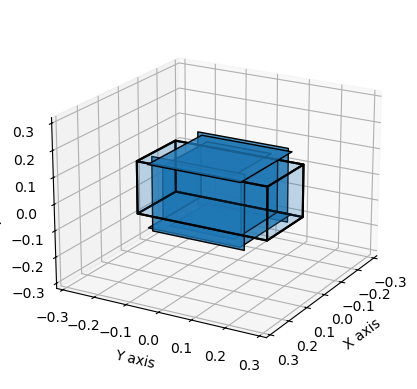

('/mnt/data/geometry_output_from_yaml.csv', '/mnt/data/geometry_render.png')

<Figure size 640x480 with 0 Axes>

In [4]:

visualize(cfg)
import matplotlib.pyplot as plt
plt.savefig("/mnt/data/geometry_render.png", dpi=160, bbox_inches="tight")
"/mnt/data/geometry_output_from_yaml.csv", "/mnt/data/geometry_render.png"
